In [2]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

# df['pct_change'] = df.close.pct_change()
# df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
# df = df.dropna()

In [4]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [5]:
df1.tail()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-05-24,NaN,NaN,NaN,NaN,0.136600,NaN,0.349877,NaN,NaN,NaN,...,0.376702,4.400221,1.590198,-0.991004,1.682900,3.364703,2.271817,0.634962,4.859794,1.204016
2021-05-25,NaN,NaN,NaN,NaN,0.946372,NaN,0.542355,NaN,NaN,NaN,...,0.230947,-0.288569,0.449063,-1.661106,0.439588,-0.548765,0.185928,0.727530,1.884279,-0.498203
2021-05-26,NaN,NaN,NaN,NaN,-1.393581,NaN,0.616491,NaN,NaN,NaN,...,1.296083,2.388001,-0.166049,3.255613,2.317760,4.702784,0.673960,2.336242,-0.429666,-1.520393
2021-05-27,NaN,NaN,NaN,NaN,-0.907923,NaN,0.102119,NaN,NaN,NaN,...,0.056867,1.893011,-0.063971,-0.510347,1.044185,-0.275482,1.979237,1.876893,1.247655,2.369727
2021-05-28,NaN,NaN,NaN,NaN,0.829804,NaN,2.116807,NaN,NaN,NaN,...,-0.312589,-0.892462,-0.409679,0.519992,0.160551,-1.549363,0.570831,0.766354,-0.444733,1.742926


In [6]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [7]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)
df1.head()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2018-05-11,1.155878,-1.483924,0.422731,0.440871,-0.916272,0.208893,0.039456,0.189573,-0.762997,0.182232,...,0.910010,-1.298276,0.524017,-2.303263,-1.639854,0.687071,-0.282002,1.212495,-2.540416,0.918045
2018-05-10,1.952862,1.506276,0.424525,0.665344,1.523657,1.131734,0.875622,-0.132526,1.430401,0.457666,...,-0.047163,-0.596383,1.208014,11.324786,1.981454,1.009464,0.658962,0.433437,2.485207,-0.570505
2018-05-09,1.175268,2.928510,0.843985,1.236468,2.364144,-1.457249,0.761981,-0.489827,0.704112,-0.568828,...,3.119572,1.616055,-3.125446,4.231626,1.659818,-0.220334,-0.151837,1.978531,-0.236128,0.219173
2018-05-08,-1.028321,0.172563,0.036708,1.366291,2.853766,-2.224484,1.176709,-0.375375,0.480665,0.595102,...,0.146117,-0.264227,-1.725105,-2.178649,0.218023,2.915452,0.335161,1.020625,0.474496,-0.398633
2018-05-07,0.987402,2.748227,0.423937,1.974362,0.868677,-0.879089,0.233859,0.832702,0.723495,-0.387597,...,0.328098,2.951477,2.178275,6.744186,-0.024219,0.652103,-1.814918,2.172496,-0.823529,-0.538091


In [8]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [9]:
train.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2016-10-14,-0.463641,4.006163,0.294874,-1.158691,0.349379,-0.367823,-0.430392,0.453096,0.555651,-0.284024,...,0.409130,-1.862765,0.351865,3.636364,0.351105,-1.812908,-0.432050,0.223839,-1.865672,-0.444939
2016-10-13,0.000000,-1.963746,-0.414125,-1.328181,-0.846805,0.854839,-0.461361,-1.406353,-0.306801,-0.330267,...,-0.684346,-0.630242,0.708717,0.917431,-1.549097,-3.092059,-0.875998,-0.334635,-3.249097,0.272648
2016-10-12,-0.437318,1.846154,0.120618,-2.865819,-1.160358,1.075970,-0.279330,0.968927,0.894239,0.118092,...,0.699903,0.704648,0.248668,1.869159,-1.276542,-1.454294,0.794663,0.223589,-0.359712,-1.139427
2016-10-11,-5.379310,-4.970760,-2.031019,-11.425005,-2.557924,-1.398489,-1.680129,-0.959629,0.215424,-2.149295,...,-2.314084,-0.422991,-1.573427,0.943396,-1.702075,-0.413793,-0.875231,-0.666297,-2.797203,-2.228079
2016-10-10,1.233419,1.333333,0.236897,0.446035,1.658187,0.679722,0.226684,0.632701,1.744696,1.453693,...,0.084219,2.207416,0.456621,-8.620690,0.274075,1.045296,-0.155355,-0.524717,1.490419,0.529865


In [10]:
test.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,1.632325,3.960396,1.150612,1.508398,-0.665643,1.080222,2.012895,1.405975,1.524422,3.981207,...,2.560616,0.781611,2.232519,-2.020202,2.325226,2.200825,2.945144,2.523060,3.903904,1.088886
2016-05-23,-0.611702,4.392765,0.162586,1.865755,1.612903,-1.332288,-0.516270,-0.122872,1.270741,1.531509,...,0.045341,-1.843109,0.211060,7.027027,1.949470,-0.068729,0.644869,2.360455,-2.489019,-0.118217
2016-05-20,0.966702,2.652520,-0.183509,-0.109406,0.698568,-0.078309,1.880778,1.082328,1.082803,3.805056,...,0.569995,2.355838,0.980392,0.543478,3.219575,0.000000,2.267731,2.768265,-0.582242,1.075397
2016-05-19,-1.350993,-1.822917,0.000000,1.108760,-1.207729,0.868878,-1.227960,-0.617175,-0.380711,2.292722,...,0.079863,1.913151,-0.339847,-0.540541,-1.412474,-2.348993,-0.689417,-1.072840,-1.079914,-0.274071
2016-05-18,0.106073,1.319261,-0.825861,-3.010928,0.520291,-1.875678,1.210962,2.364621,1.144507,0.053348,...,-0.034215,3.180885,-0.211954,3.351955,1.481720,-0.996678,2.690265,0.084770,3.889304,0.226920


In [11]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)
pd.DataFrame(training_set_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,634,635,636,637,638,639,640,641,642,643
0,0.681938,0.561247,0.534958,0.667773,0.285284,0.618457,0.386756,0.721853,0.342626,0.560088,...,0.546874,0.461215,0.451240,0.266433,0.399997,0.413940,0.525361,0.642595,0.145999,0.662292
1,0.765102,0.635032,0.535151,0.674886,0.401511,0.767389,0.443800,0.696633,0.552781,0.577114,...,0.496270,0.505375,0.497635,0.602618,0.683300,0.429399,0.575786,0.582642,0.374450,0.589851
2,0.683961,0.670126,0.580098,0.692984,0.441548,0.349568,0.436048,0.668657,0.483193,0.513660,...,0.663689,0.644571,0.203700,0.427640,0.658137,0.370430,0.532337,0.701547,0.250746,0.628281
3,0.454020,0.602122,0.493594,0.697097,0.464871,0.225748,0.464341,0.677619,0.461784,0.585610,...,0.506489,0.526273,0.298684,0.269507,0.545343,0.520791,0.558434,0.627830,0.283049,0.598215
4,0.664358,0.665677,0.535088,0.716366,0.370311,0.442874,0.400019,0.772208,0.485050,0.524863,...,0.516109,0.728590,0.563447,0.489621,0.526392,0.412264,0.443215,0.716474,0.224044,0.591428


## 1. Simple multi-layer percepetron (MLP) autoencoder

In [42]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 500

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

    def model(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc','mae']) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=1024,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_53 (Dense)             (None, 20)                12900     
_________________________________________________________________
dense_54 (Dense)             (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.2820 - acc: 0.0031 - mae: 0.4959 - val_loss: 0.2733 - val_acc: 0.0000e+00 - val_mae: 0.4859
Epoch 2/500
1/1 [==============================] - 0s 31ms/step - loss: 0.2686 - acc: 0.0000e+00 - mae: 0.4830 - val_loss: 0.2630 - val_acc: 0.0000e+00 - val_mae: 0.4746
Epoch 3/500
1/1 [==============================] -

Epoch 45/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0148 - acc: 0.0000e+00 - mae: 0.0859 - val_loss: 0.0163 - val_acc: 0.0000e+00 - val_mae: 0.0899
Epoch 46/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0143 - acc: 0.0000e+00 - mae: 0.0845 - val_loss: 0.0158 - val_acc: 0.0000e+00 - val_mae: 0.0886
Epoch 47/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0138 - acc: 0.0063 - mae: 0.0831 - val_loss: 0.0154 - val_acc: 0.0000e+00 - val_mae: 0.0874
Epoch 48/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0134 - acc: 0.0063 - mae: 0.0820 - val_loss: 0.0151 - val_acc: 0.0000e+00 - val_mae: 0.0863
Epoch 49/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0131 - acc: 0.0094 - mae: 0.0809 - val_loss: 0.0148 - val_acc: 0.0000e+00 - val_mae: 0.0853
Epoch 50/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0128 - acc: 0.0094 - mae: 0.0799 - val_loss: 0.0145 - val_acc: 0.0000e+00 - val_ma

1/1 [==============================] - 0s 53ms/step - loss: 0.0099 - acc: 0.1875 - mae: 0.0685 - val_loss: 0.0120 - val_acc: 0.1500 - val_mae: 0.0739
Epoch 95/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0099 - acc: 0.1875 - mae: 0.0685 - val_loss: 0.0120 - val_acc: 0.1500 - val_mae: 0.0739
Epoch 96/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0099 - acc: 0.1875 - mae: 0.0685 - val_loss: 0.0120 - val_acc: 0.1500 - val_mae: 0.0739
Epoch 97/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0099 - acc: 0.1875 - mae: 0.0684 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0739
Epoch 98/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0099 - acc: 0.1875 - mae: 0.0684 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 99/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0098 - acc: 0.1875 - mae: 0.0684 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 100/500
1/1 [================

1/1 [==============================] - 0s 28ms/step - loss: 0.0092 - acc: 0.1844 - mae: 0.0659 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0719
Epoch 145/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0092 - acc: 0.1844 - mae: 0.0658 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0718
Epoch 146/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0092 - acc: 0.1813 - mae: 0.0657 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0718
Epoch 147/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0091 - acc: 0.1813 - mae: 0.0657 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0718
Epoch 148/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0091 - acc: 0.1813 - mae: 0.0656 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0717
Epoch 149/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0091 - acc: 0.1813 - mae: 0.0656 - val_loss: 0.0115 - val_acc: 0.1500 - val_mae: 0.0717
Epoch 150/500
1/1 [===========

1/1 [==============================] - 0s 36ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0639 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0703
Epoch 195/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0639 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0703
Epoch 196/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0638 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0703
Epoch 197/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0638 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0703
Epoch 198/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0638 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0703
Epoch 199/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0638 - val_loss: 0.0111 - val_acc: 0.1500 - val_mae: 0.0702
Epoch 200/500
1/1 [===========

1/1 [==============================] - 0s 37ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0627 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0694
Epoch 245/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0627 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0694
Epoch 246/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0627 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0694
Epoch 247/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0627 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0694
Epoch 248/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0627 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0694
Epoch 249/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0084 - acc: 0.1781 - mae: 0.0626 - val_loss: 0.0109 - val_acc: 0.1500 - val_mae: 0.0693
Epoch 250/500
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0620 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0688
Epoch 295/500
1/1 [==============================] - 0s 39ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0619 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0688
Epoch 296/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0619 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0687
Epoch 297/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0619 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0687
Epoch 298/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0619 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0687
Epoch 299/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0082 - acc: 0.1813 - mae: 0.0619 - val_loss: 0.0107 - val_acc: 0.1500 - val_mae: 0.0687
Epoch 300/500
1/1 [===========

1/1 [==============================] - 0s 30ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0613 - val_loss: 0.0106 - val_acc: 0.1500 - val_mae: 0.0683
Epoch 345/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0613 - val_loss: 0.0106 - val_acc: 0.1500 - val_mae: 0.0683
Epoch 346/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0613 - val_loss: 0.0105 - val_acc: 0.1500 - val_mae: 0.0682
Epoch 347/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0613 - val_loss: 0.0105 - val_acc: 0.1500 - val_mae: 0.0682
Epoch 348/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0613 - val_loss: 0.0105 - val_acc: 0.1500 - val_mae: 0.0682
Epoch 349/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0081 - acc: 0.1813 - mae: 0.0612 - val_loss: 0.0105 - val_acc: 0.1500 - val_mae: 0.0682
Epoch 350/500
1/1 [===========

1/1 [==============================] - 0s 39ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0678
Epoch 395/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0677
Epoch 396/500
1/1 [==============================] - 0s 38ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0677
Epoch 397/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0677
Epoch 398/500
1/1 [==============================] - 0s 33ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0677
Epoch 399/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0079 - acc: 0.1813 - mae: 0.0606 - val_loss: 0.0104 - val_acc: 0.1500 - val_mae: 0.0677
Epoch 400/500
1/1 [===========

1/1 [==============================] - 0s 31ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 445/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 446/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 447/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 448/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 449/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0077 - acc: 0.1813 - mae: 0.0599 - val_loss: 0.0102 - val_acc: 0.1500 - val_mae: 0.0672
Epoch 450/500
1/1 [===========

In [43]:
simple_autoencoder().reduced_dim()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.253874,0.108061,-0.701503,-0.730775,0.362164,0.202069,0.217054,0.323640,0.798893,0.086669,-0.029927,0.870718,-0.483008,-0.361751,0.144097,-0.165063,-0.431446,-0.401243,-0.305907,-0.370328
1,-0.108600,0.183218,-0.714460,-0.712744,0.619875,0.250855,0.470326,0.410083,0.717201,0.020788,0.134166,0.847102,-0.425439,-0.416016,0.139242,0.128938,-0.581184,-0.308913,-0.526256,-0.565992
2,0.017777,0.266416,-0.630921,-0.649905,0.426936,0.234227,0.527329,0.525547,0.891732,-0.216279,0.117406,0.931062,-0.513410,-0.262765,-0.063280,0.151675,-0.440844,-0.511183,-0.584432,-0.580721
3,0.080044,0.221360,-0.651152,-0.613587,0.418594,-0.023749,0.044255,0.305970,0.552357,0.182876,-0.099578,0.898218,-0.480421,-0.399982,0.220741,-0.018310,-0.378346,-0.393864,-0.229432,-0.586607
4,0.098448,0.187826,-0.655765,-0.721442,0.126462,0.178148,0.099366,0.234990,0.629338,-0.261646,0.309820,0.846419,-0.277255,-0.290999,-0.180330,0.347799,-0.470017,-0.195855,-0.524071,-0.578214


In [ ]:
# # calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# # windows of train.shape[1] consecutive returns will be produced. 
# # Can be normalized with a MinMaxScaler to the range [0,1]??

# window_length = training_set_scaled.shape[1]
# encoding_dim = 20
# epochs = 500

# # compress the input to a 3-dimensional latent space. 

# # input placeholder
# input_window = Input(shape=(window_length,))
# # encoded representation of the input
# encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# # lossy reconstruction of the input
# decoded = Dense(window_length, activation='linear')(encoded) #linear

# # model mapping an input to its reconstruction
# simple_autoencoder = Model(input_window, decoded)

# # model mapping an input to its encoded representation
# encoder = Model(input_window, encoded)

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
# checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)

# simple_autoencoder.summary()
# sae = simple_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc','mae']) #MSE
# sae
# history = simple_autoencoder.fit(training_set_scaled, training_set_scaled,
#                 epochs=epochs,
#                 batch_size=1024,
#                 shuffle=True,
#                 validation_split = 0.2,
#                 callbacks = [monitor, checkpointer])       
# #               validation_data=(test_set_scaled, test_set_scaled))

# decoded_stocks = simple_autoencoder.predict(test_set_scaled)

In [ ]:
# pd.DataFrame(encoder.predict(test_set_scaled)).head()

In [ ]:
# pd.DataFrame(decoded_stocks).head()

In [44]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_acc"])
    plt.title("Accuracy")
    ax = plt.subplot(1, 4, 4)
    plt.plot(history.history["val_mae"])
    plt.title("Mean Absolute Error")

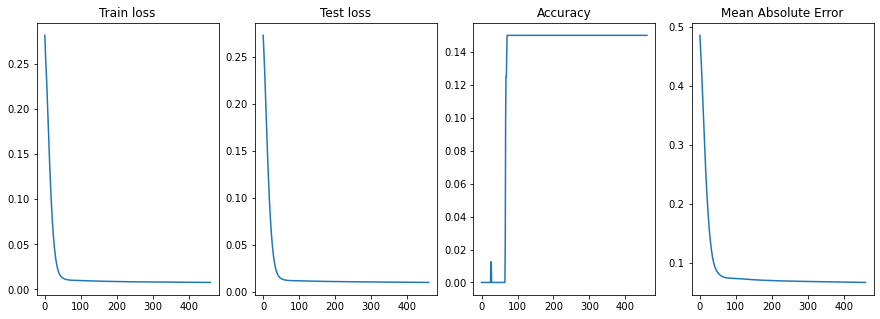

In [45]:
# Loss vs Epoch
plot_history(history)

### 2. 1D convolutional autoencoder
(Kernel size = 3)

In [ ]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims
encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
conv_autoencoder = Model(input_window, decoded)
conv_autoencoder.summary()

conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc','mae'])
history = conv_autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_split = 0.2)

decoded_stocks = conv_autoencoder.predict(test)

In [ ]:
plot_history(history)

In [ ]:
#pd.DataFrame(encoder.predict(test_set_scaled))

## 3. Multiple Layers w/ L1 Regularization

In [ ]:
import tensorflow as tf

def model(optimizer = "Adam", score = "acc"):
    #Input Layer
    input_layer = Input(shape =(df.shape[1], ))
  
    #Encode
    encoded = Dense(100, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(25, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(12, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(6, activation ='relu')(encoded)

    #Decoder
    decoded = Dense(12, activation ='linear')(encoded)
    decoded = Dense(25, activation ='linear')(decoded)
    decoded = Dense(50, activation ='linear')(decoded)
    decoded = Dense(100, activation ='linear')(decoded)

    #Output
    output_layer = Dense(df.shape[1], activation ='linear')(decoded)

    #Parameters
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer =optimizer, loss =tf.keras.losses.MeanSquaredError(), metrics = ['acc','mae'])
    
    return autoencoder

In [ ]:
# Training the Auto-encoder network
output = model().fit(training_set_scaled, training_set_scaled,
                batch_size = 16, epochs = 100, 
                shuffle = True, validation_split = 0.2)
output

In [ ]:
plot_history(output)

## Hyper-parameter Tuning

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(simple_autoencoder().model, verbose=1, batch_size=10, epochs=10)
#define the grid search parameters
#dimensions = []
#dropout = []
batch_size = [10,20]
loss = ['mean_squared_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
epochs = [10, 15]
scoring = ['acc']

param_grid = dict(optimizer=optimizer,score = scoring)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf6",save_best_only=True)

grid = GridSearchCV(estimator=model_regressor, param_grid=param_grid, 
                    n_jobs=1, cv = 3)

## Error
grid_result = grid.fit(df,df, callbacks=[monitor,checkpointer]) # X, y?

grid_best_parameters = grid_result.best_params_
grid_best_accuracy = grid_result.best_score_

ValueError: optimizer is not a legal parameter

In [ ]:
grid_best_parameters

In [ ]:
grid_best_accuracy

In [47]:
random_search = RandomizedSearchCV(estimator=simple_autoencoder().model, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

random_best_parameters = grid_result.best_params_
random_best_accuracy = grid_result.best_score_

TypeError: estimator should be an estimator implementing 'fit' method, <bound method simple_autoencoder.model of <__main__.simple_autoencoder object at 0x7fd1cdeb3c10>> was passed

In [ ]:
random_best_parameters

In [ ]:
random_best_accuracy

## Notes

- Code's working fine now, there are about 3 different autoencoders here, Simple, Convolutional and one with multiple layers and regularization.
- Performed hyp tuning on the last autoencoder model with multiple layers
- The only thing we need to do is add the parameters in model() and param_grid. At the moment, I've only tried optimizer and score. 
- Makes those changes here: 
    - def model(optimizer = "Adam", score = "acc", epoch = '', batch_size= '',....)
    - param_grid = dict(optimizer=optimizer,score = scoring, epoch = ....)
- Parameters we need to add: no. of Dimensions of our dataframe, loss function, epochs, batch_size, dropout